# Tuples Statistics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from hard_rules import candidate_cookies

In [2]:
# from tqdm.notebook import tqdm
from tqdm import tqdm

In [47]:
sns.set(rc={'figure.figsize':(12,5)})

In [4]:
data = pd.read_parquet("data.parquet")

In [26]:
tuple_size = 4

all_cookie_tuples = []
# while not found:
random_hh_id = np.random.choice(data['hh_id'])
random_h = data[data['hh_id']==random_hh_id]
if random_h['iiqid'].nunique() > 1:
    for cookie_tuple in itertools.combinations(random_h['iiqid'].unique(), r=tuple_size):
        test_first_pair = candidate_cookies(random_h, cookie_tuple[0], cookie_tuple[1])
        test_second_pair = candidate_cookies(random_h, cookie_tuple[1], cookie_tuple[2])
        if test_first_pair and test_second_pair:
            all_cookie_tuples.append(cookie_tuple)
print(f"found {len(all_cookie_tuples)} {tuple_size}-tuples on HH {random_hh_id}")

found 0 4-tuples on HH 0009WUFKqK


## First - pairs

In [33]:
tuple_size = 2

# i = 0
all_cookie_tuples = dict()
for hh in tqdm(data.hh_id.unique()):
    all_cookie_tuples[hh] = []
    house = data[data['hh_id']==hh]
    if house['iiqid'].nunique() > 1:
        for cookie_tuple in itertools.combinations(house['iiqid'].unique(), r=tuple_size):
            test_pairs = [candidate_cookies(house, c1, c2) 
                          for c1, c2 in zip(cookie_tuple, cookie_tuple[1:])]
            if all(test_pairs):
                all_cookie_tuples[hh].append(cookie_tuple)   

100%|█████████████████████████████████████████| 989/989 [00:44<00:00, 22.26it/s]


In [63]:
def cookie_amount(v):
    return len(all_cookie_tuples.get(v))
               
# [len(v) for v in all_cookie_tuples.values()])
max(all_cookie_tuples, key=cookie_amount)

'006OpKMkK2'

In [64]:
k = '006OpKMkK2'
len(data.loc[data['hh_id']==k, 'iiqid'])

592

In [92]:
pairs_count = pd.Series({k: len(v) for k, v in all_cookie_tuples.items()}, 
             index=all_cookie_tuples.keys(), name='pairs')

In [99]:
pairs_data = pd.concat([pairs_count,data.groupby('hh_id').count().iiqid], axis=1)
pairs_data.columns = ['pairs', 'cookies']

<Axes: xlabel='cookies', ylabel='pairs'>

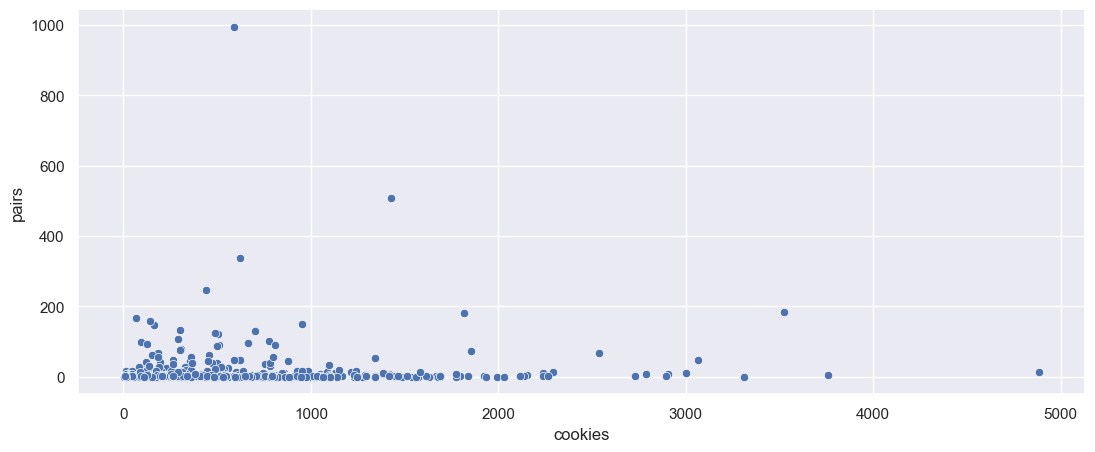

In [101]:
sns.scatterplot(data=pairs_data, x='cookies', y='pairs')

## Now 3-tupes

In [102]:
tuple_size = 3

# i = 0
all_cookie_tuples = dict()
for hh in tqdm(data.hh_id.unique()):
    all_cookie_tuples[hh] = []
    house = data[data['hh_id']==hh]
    if house['iiqid'].nunique() > 1:
        for cookie_tuple in itertools.combinations(house['iiqid'].unique(), r=tuple_size):
            test_pairs = [candidate_cookies(house, c1, c2) 
                          for c1, c2 in zip(cookie_tuple, cookie_tuple[1:])]
            if all(test_pairs):
                all_cookie_tuples[hh].append(cookie_tuple)   

100%|█████████████████████████████████████████| 989/989 [08:32<00:00,  1.93it/s]


In [105]:
three_tuples_count = pd.Series({k: len(v) for k, v in all_cookie_tuples.items()}, 
             index=all_cookie_tuples.keys(), name='3-tupes')
three_data = pd.concat([three_tuples_count,data.groupby('hh_id').count().iiqid], axis=1)
three_data.columns = ['3-tupes', 'cookies']

## Wait Lets do 2 to 4 togheter

In [ ]:
houses_cookies_tuples = dict()

for hh in tqdm(data.hh_id.unique(), desc="Houses"):
    houses_cookies_tuples[hh] = dict()
    house = data[data['hh_id']==hh]
    
    # for ts in tqdm(range(2,5), desc="Tuple Size", position=1, leave=False):
    for ts in range(2,5):
        tuple_size = ts   
        houses_cookies_tuples[hh][ts] = []

        if house['iiqid'].nunique() > 1:
            for cookie_tuple in itertools.combinations(house['iiqid'].unique(), r=tuple_size):
                test_pairs = [candidate_cookies(house, c1, c2) 
                              for c1, c2 in zip(cookie_tuple, cookie_tuple[1:])]

                if all(test_pairs):
                    houses_cookies_tuples[hh][ts].append(cookie_tuple)   

## Some EDA

In [6]:
data['constans'] = data[['hh_id',"brand", "model", "os", "browser", "advertisedbrowser"]].apply(lambda x: hash(tuple(x)), axis = 1)

In [7]:
grouped_by_consts = data.groupby('constans')['iiqid'].nunique()

Text(0.5, 0, 'Distinct Cookies')

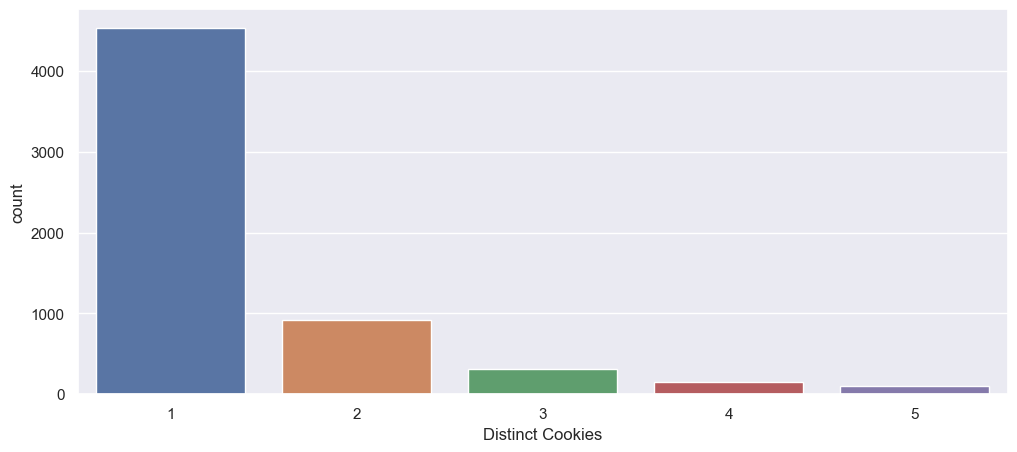

In [8]:
# plt.xticks(range(1,6))
sns.countplot(x=grouped_by_consts[grouped_by_consts < 6])
plt.xlabel("Distinct Cookies")

In [9]:
browsers_data = pd.DataFrame()
for b in data['browser'].unique():
    unique_b = data[data['browser']==b].groupby('constans')['iiqid'].nunique()
    unique_df = pd.DataFrame(unique_b)
    unique_df['browser'] = b
    browsers_data = pd.concat([browsers_data, unique_df])

Text(0.5, 0, 'Distinct Cookies')

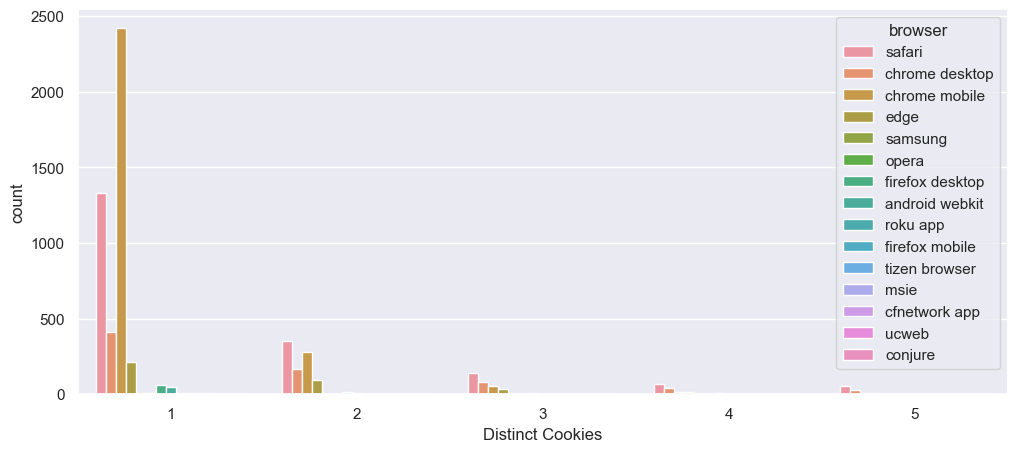

In [10]:
sns.countplot(data=browsers_data[browsers_data['iiqid'] < 6], x='iiqid', hue='browser')
plt.xlabel("Distinct Cookies")

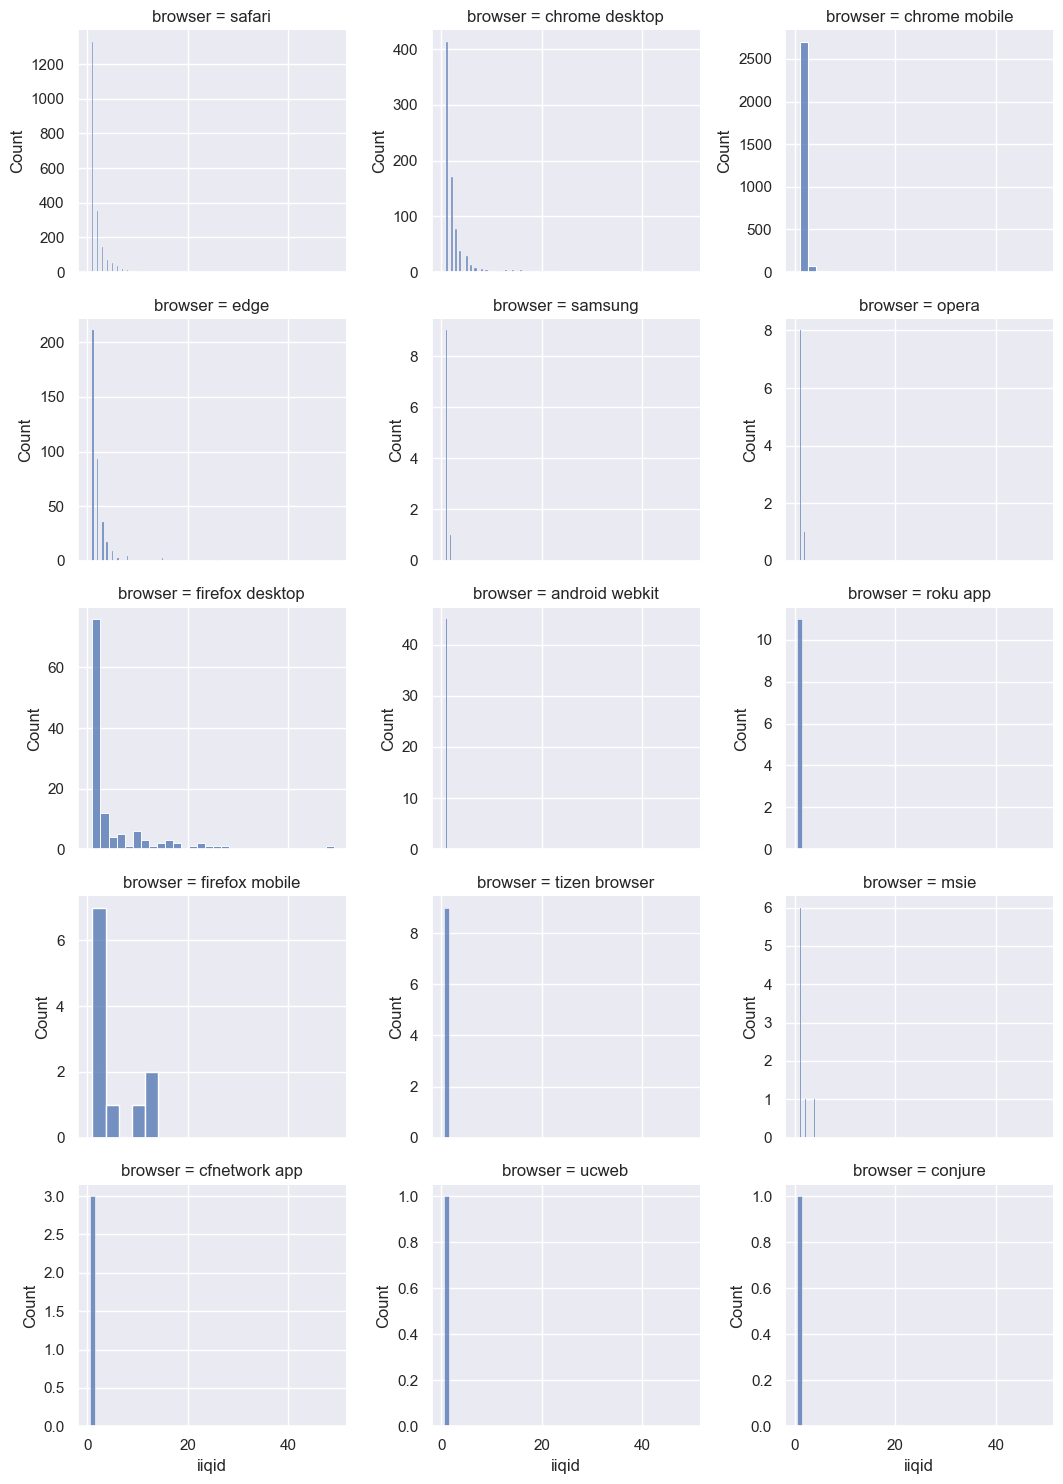

In [13]:
g = sns.FacetGrid(data=browsers_data, col='browser', col_wrap=3, sharey=False, aspect=1.2)
g.map(sns.histplot, 'iiqid')

In [18]:
browsers_data['count'] = browsers_data['iiqid'].apply(lambda x: min(x, 6))

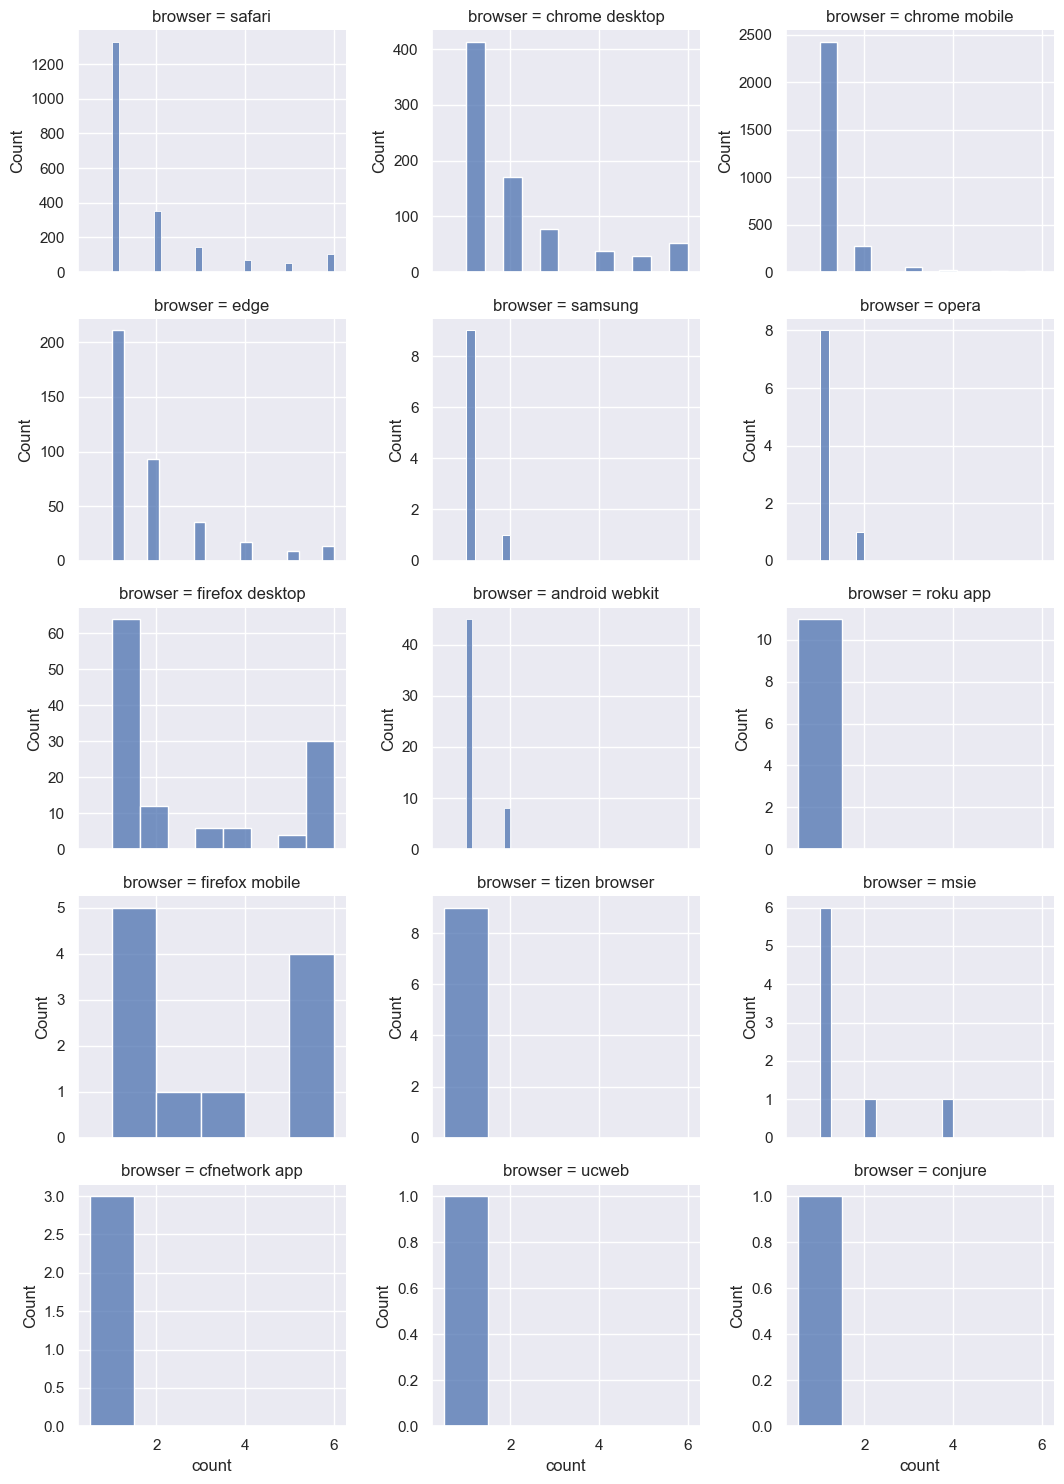

In [19]:
g = sns.FacetGrid(data=browsers_data, col='browser', col_wrap=3, sharey=False, aspect=1.2)
g.map(sns.histplot, 'count')

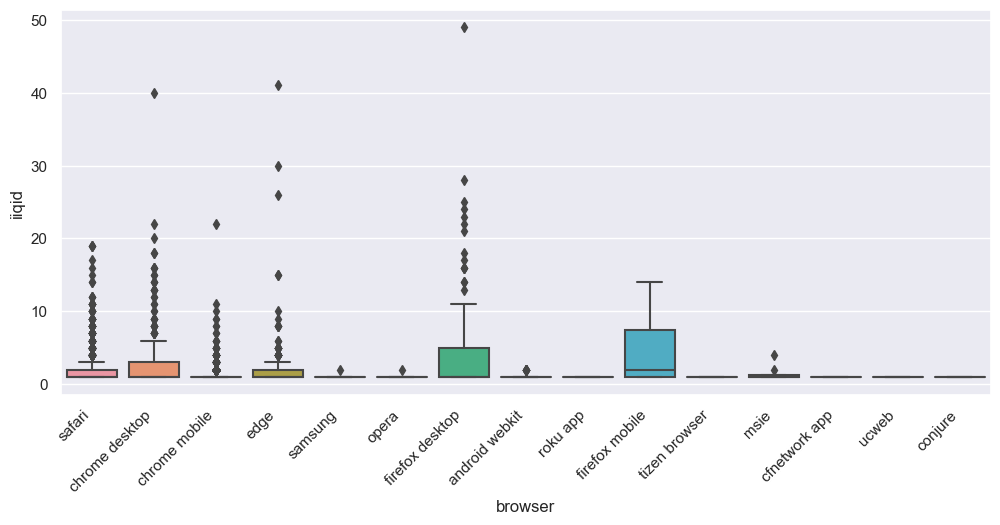

In [20]:
# sorted_index = browsers_data.median().sort_values().index
sns.boxplot(data=browsers_data, y='iiqid', x='browser')
plt.xticks(rotation=45,  ha='right', va='top');

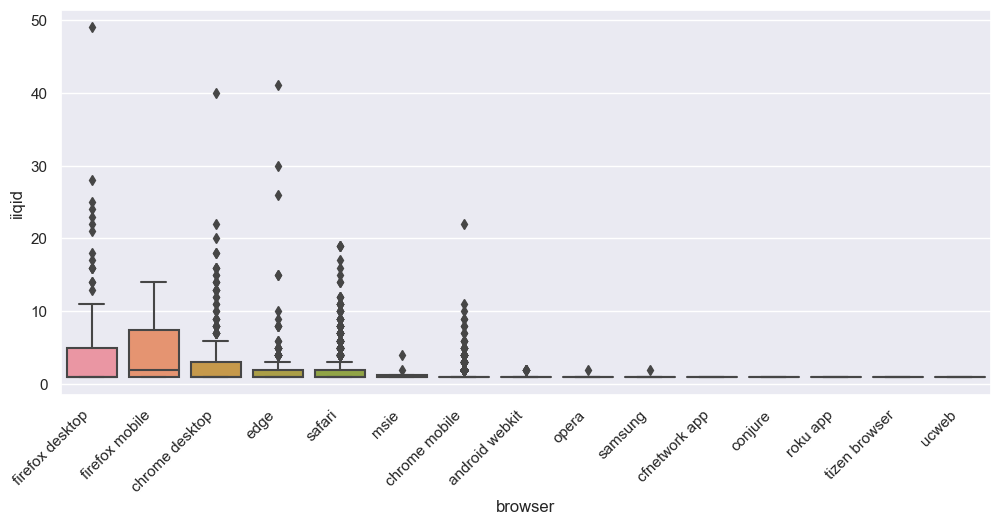

In [21]:
browsers_counts = browsers_data.groupby('browser')['iiqid'].mean().sort_values(ascending=False)
browsers_order = browsers_counts.index.tolist()
sns.boxplot(data=browsers_data, y='iiqid', x='browser', order=browsers_order)
plt.xticks(rotation=45,  ha='right', va='top');

In [22]:
pd.DataFrame({'mean': browsers_counts})

,mean
browser,
firefox desktop,4.860656
firefox mobile,4.727273
chrome desktop,2.366667
edge,2.129630
safari,1.886719
msie,1.500000
chrome mobile,1.204228
android webkit,1.150943
opera,1.111111


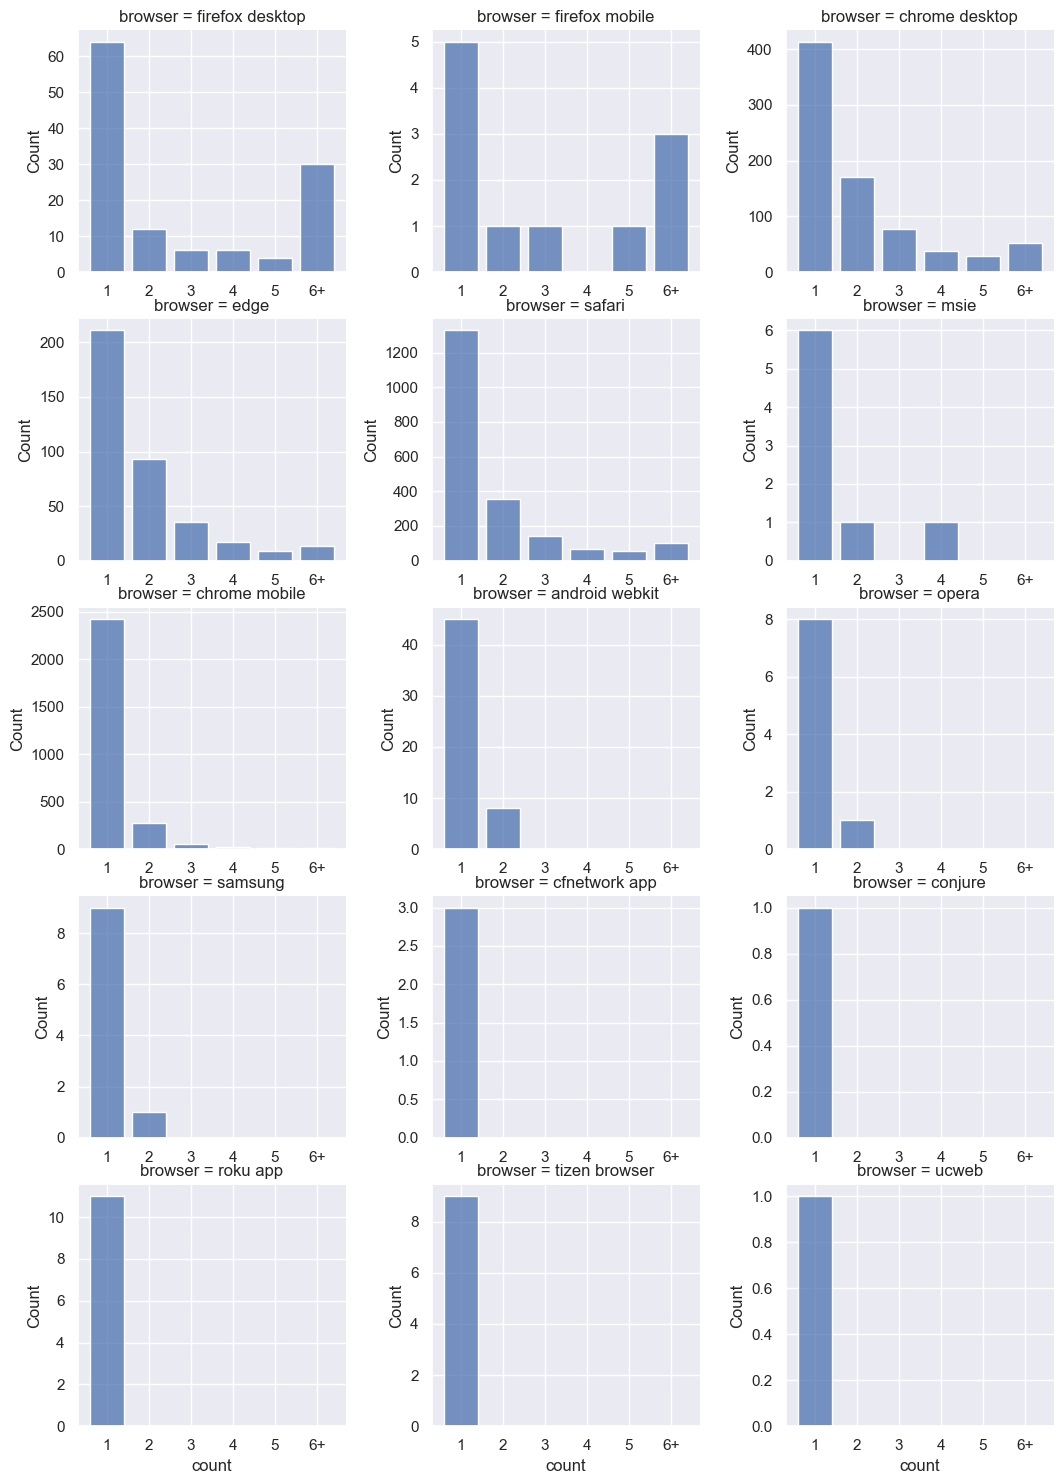

In [48]:
g = sns.FacetGrid(data=browsers_data, col='browser', 
                  col_wrap=3, col_order=browsers_order, sharey=False, aspect=1.2)
g.map(sns.histplot, 'count', bins=6, discrete=True, shrink=0.8)
g.set(xticks=np.arange(1,7))
g.set_xticklabels(['1','2','3','4','5','6+'])
g.fig.tight_layout()
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

## Data from Atena

In [50]:
atena_data = pd.read_csv("cookies_counts.csv")

In [51]:
atena_data.head()

,num_distinct_iiqid,num_groups
0,24,33705
1,627,4
2,2381,1
3,392,1
4,1821,1
